# Preliminary test

# Reference genome testing - Preprocessing

<div class="alert alert-warning">

**What this notebook collection does**
    
This notebook compares the Cell Ranger alignment results from mouse references mm10 (Ensembl 93), using Cell Ranger v3.0 and mm10 (GENCODE vM23/Ensembl 98), using Cell Ranger v6.1 to see if realignment is necessary. The collection of notebooks contains five main sections: 1) Preprocessing, 2) Filtering, 3) Normalization and Clustering, 4) Merging and Clustering
    
<br>   
    
**What the first section (Preprocessing) does**
    
This section takes the aligned h5 files and shapes the data with annotations and quality control metrics. This additional information will be used to filter the data and prepare it for subsequent processing. For each h5 file a <sample_name>_preprocessed.h5ad file will be made which contain all necessary annotation for subsequent filtering. The section contains the following important subsections:

* Doublet detection <br>
* Adding quality metrics and mitochondrial gene removal<br>
  
    
<br>   
    
**What the second section (Filtering) does**

This section visualizes various quality control metric values and filters the data based on a threshold made on the observations/domain knowledge. The section contains the following subsections:

* Doublet filtering <br>
* UMIs and gene counts filtering <br>
    
<br> 
    
**What the third section (Normalization) does**
    
This section normalizes the data based on sequencing depth and gene length so the cells are comparable. Subsequently dimensional reduction and clustering are performed to visualize samples separately. The section contains the following subsections:

* Normalization <br>
* Dimensional reduction <br>
* Marker genes and property annotation visualizations <br>
    
<br>
    
**What the fourth section (Merging and Clustering) does**
    
This section merges the different datasets and visualizes the merged data. The section contains the following subsections:

* Merging <br>
* Alignment parameter visualization <br>
    
</div>  



### Loading libraries
Using sc2_seurat environment, importing packages and setting parameters.

In [3]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/bin/python
3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:40:17) 
[GCC 9.4.0]
sys.version_info(major=3, minor=9, micro=9, releaselevel='final', serial=0)


In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))#embed HTML within IPython notebook and make containers 90% of screen
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import matplotlib.pyplot as plt

%matplotlib inline
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white') #figure resolution and background color

# This is used
# os.path.join('data/'+object_names[i][6:10]+'_preprocessed.h5ad')
#sc.logging.print_versions()

### Cell Ranger files

In [239]:
#old (ensemble 93)
old_raw = '/hpc/hers_basak/rnaseq_data/Basaklab/jjiang//outputs/count_files/mus_mus/zhong_2021/old/CNR0176487/outs/filtered_feature_bc_matrix.h5'

#new (ensemble 98)
new_raw = '/hpc/hers_basak/rnaseq_data/Basaklab/jjiang//outputs/count_files/mus_mus/zhong_2021/new/CNR0176487/outs/filtered_feature_bc_matrix.h5'


In [240]:
#set data path
os.chdir('/home/hers_basak/jjiang/jack/outputs/deliverables/0_reference_testing/')

In [241]:
os.getcwd()

'/hpc/hers_basak/rnaseq_data/Basaklab/jjiang/outputs/deliverables/0_reference_testing'

## Load data
The .h5 files from 10x that we are using contains feature and barcode information. Empty barcodes are already filtered out from these files.

In [242]:
files = [old_raw, new_raw]
names = ['CNR0176487_old', 'CNR0176487_new'] #the number is the run ID on cngb
numberobj = len(names)

object_names = list()

#locals() returns dictionary with all local variables and symbols
for i in range(numberobj):
    locals()["adata"+"_"+names[i]] = sc.read_10x_h5(files[i])
    locals()["adata"+"_"+names[i]].var_names_make_unique()
    print("adata"+"_"+names[i],"is loaded")
    
    object_names.append("adata"+"_"+names[i]) # make list of objects for later

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


adata_CNR0176487_old is loaded


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


adata_CNR0176487_new is loaded


In [243]:
adata_CNR0176487_old #gene annotation

AnnData object with n_obs × n_vars = 5668 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

## Basic Preprocessing
### Doublet detection using scrublet
Doublets are droplets that captures two cells, which will lead to inconsistencies. So we need to detect and remove them. First we will annotate the objects with metadata.

https://github.com/swolock/scrublet
https://www.sciencedirect.com/science/article/pii/S2405471218304745

Following the advice of Chromium (below), for 5668 cells recovered, ~4.32% doublets are to be expected
> https://uofuhealth.utah.edu/huntsman/shared-resources/gba/htg/single-cell/genomics-10x.php


In [244]:
names

['CNR0176487_old', 'CNR0176487_new']

In [245]:
object_names

['adata_CNR0176487_old', 'adata_CNR0176487_new']

(5668, 31053)
(5678, 32285)


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 40.2%
Overall doublet rate:
	Expected   = 4.3%
	Estimated  = 5.9%


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Detected doublet rate = 2.7%
Estimated detectable doublet fraction = 41.5%
Overall doublet rate:
	Expected   = 4.3%
	Estimated  = 6.6%


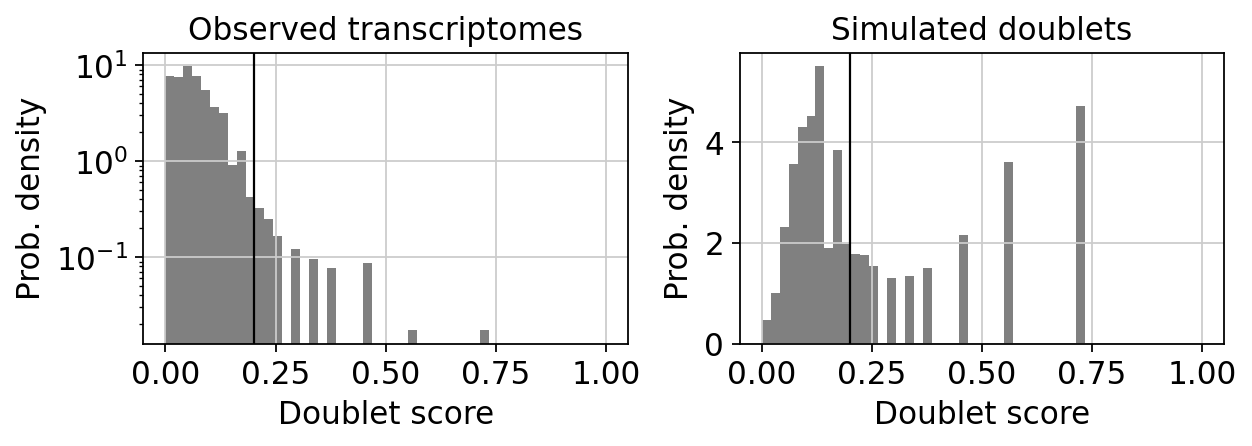

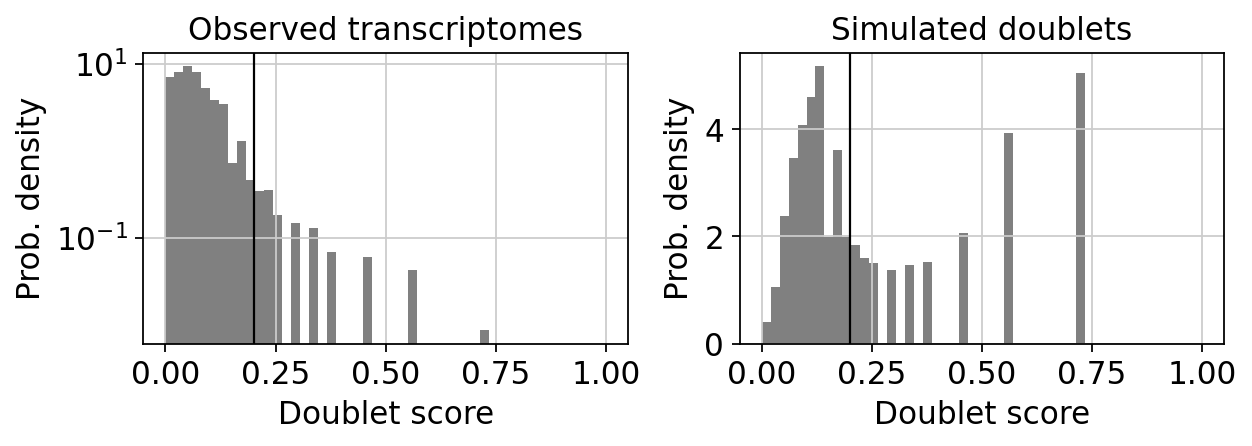

In [246]:
#manually adding metadata due to lack of metadata file
for i in range(numberobj):
    locals()[object_names[i]].obs['species'] = ['Mus musculus','Mus musculus'][i]
    locals()[object_names[i]].obs['gender'] = ['male','male'][i]
    locals()[object_names[i]].obs['age'] = ['6 months','6 months'][i]
    locals()[object_names[i]].obs['cngb_sample_id'] = ['CNS0195744','CNS0195744'][i]
    locals()[object_names[i]].obs['sample_name'] = names[i]
    
#viewing object annotations
for i in range(numberobj):
    print(locals()[object_names[i]].shape)
    
#determine expected doublet rate with 10X Genomics User Guide (5668 objects,recovered -> ~4.32%)
thr = 0.20
for i in range(numberobj):
    #predicts doublets and adds a score to objects
    sc.external.pp.scrublet(locals()[object_names[i]], expected_doublet_rate=0.0432, stdev_doublet_rate=0.02, 
                            synthetic_doublet_umi_subsampling=1.0, knn_dist_metric='euclidean', normalize_variance=True, 
                            log_transform=False, mean_center=True, n_prin_comps=30, use_approx_neighbors=True, 
                            get_doublet_neighbor_parents=False, n_neighbors=None, threshold=thr, verbose=True, copy=False, random_state=0)
    #plot histogram of doublet scores(doesnt work in loop)
    sc.external.pl.scrublet_score_distribution(locals()[object_names[i]], scale_hist_obs='log', scale_hist_sim='linear', figsize=(8, 3),
                                               show=True,return_fig=True)


Check how many cells are higher than the threshold

In [247]:
for i in range(numberobj):
    print(locals()[object_names[i]].obs['predicted_doublet'].value_counts())

False    5534
True      134
Name: predicted_doublet, dtype: int64
False    5523
True      155
Name: predicted_doublet, dtype: int64


### Add QC and get rid of mitochondrial genes

In [248]:
adata_CNR0176487_new


AnnData object with n_obs × n_vars = 5678 × 32285
    obs: 'species', 'gender', 'age', 'cngb_sample_id', 'sample_name', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'scrublet'

<b> check this: sc.pp.calculate_qc_metrics() </b> <br>
expr_type: kind of values in X (str)<br>
var_type: kind of variables (str)<br>
qc_vars: keys for variables you want to control (collection of str)<br>
percent_top: proportions of top genes to cover, for cummulative proportion of counts (collection of int)<br>
layer: alternative layers for expression data (str)<br>
use_raw: use adata.raw.X for expression values (bool)<br>
inplace: place metrics in adata (bool)<br>
log1p: compute log1p transformed annotations, for very small values (bool)<br>
<br>
<b> return features obs </b> <br>
n_genes_by_counts: The number of genes with at least 1 count in a cell. <br>
total_counts: Total number of counts for a cell. <br>
total_counts_mt:Total number of mt gene counts for a cell. <br>
pct_counts_mt: Proportion (%) of total counts for a cell which are mitochondrial. <br> 
n_genes: Number of genes with a positive count. <br>
total_counts_ribo: Total number of ribosomal counts for a cell. <br>
pct_counts_ribo: Proportion of total counts for a cell which are ribosomal.

In [249]:
import numpy as np

for i in range(numberobj):
    #add mt variable annotation indicating if a gene is ribosomal or not (bool)
    if locals()[object_names[i]].obs['species'][0] == 'Homo sapiens':
        locals()[object_names[i]].var['mt'] = locals()[object_names[i]].var_names.str.startswith('MT-')
    elif locals()[object_names[i]].obs['species'][0] == 'Mus musculus':
        locals()[object_names[i]].var['mt'] = locals()[object_names[i]].var_names.str.startswith('mt-') 
        
    if locals()[object_names[i]].obs['species'][0] == 'Homo sapien':
        locals()[object_names[i]].var['ribo'] = locals()[object_names[i]].var_names.str.startswith('RP')
    elif locals()[object_names[i]].obs['species'][0] == 'Mus musculus':
        locals()[object_names[i]].var['ribo'] = locals()[object_names[i]].var_names.str.startswith('Rp')
    
    sc.pp.calculate_qc_metrics(locals()[object_names[i]], expr_type='counts', var_type='genes', qc_vars=('mt','ribo'), percent_top= (), layer= None, use_raw= False, inplace=True, log1p=True)
     
    locals()[object_names[i]].var_names_make_unique()
    sc.pp.filter_cells(locals()[object_names[i]], min_genes=1) #remove all cells with 0 genes
                 
    # The following is to solve a save issue. Probably because of the NA valies in ther 'predicted_doublet' slot
    locals()[object_names[i]].obs['predicted_doublet'] =  locals()[object_names[i]].obs['predicted_doublet'].astype('str')

    

Checking median number of mitochondrial genes, genes and UMIs per cell to have an idea of the quality of each run:

In [250]:
print("Median numbers before filtering mt genes")
for i in range(numberobj):
    print(
         object_names[i],"\tmito%:",np.median(locals()[object_names[i]].obs['pct_counts_mt']),"\tmedian genes/nuclei:",np.median(locals()[object_names[i]].obs['n_genes']), 
            "\tmedian reads/nuclei:",np.median(locals()[object_names[i]].obs['total_counts']),
           "\tmean genes/nuclei:",int(np.mean(locals()[object_names[i]].obs['n_genes'])),
         "\tmean reads/nuclei:",  int(np.mean(locals()[object_names[i]].obs['total_counts'])))
    

Median numbers before filtering mt genes
adata_CNR0176487_old 	mito%: 0.2387902 	median genes/nuclei: 1798.0 	median reads/nuclei: 3306.0 	mean genes/nuclei: 1794 	mean reads/nuclei: 3541
adata_CNR0176487_new 	mito%: 0.2345206 	median genes/nuclei: 1827.5 	median reads/nuclei: 3360.5 	mean genes/nuclei: 1825 	mean reads/nuclei: 3598


In [251]:
print(adata_CNR0176487_new)
print(adata_CNR0176487_new.obs['total_counts'])
print(adata_CNR0176487_new.obs['pct_counts_mt'])

AnnData object with n_obs × n_vars = 5678 × 32285
    obs: 'species', 'gender', 'age', 'cngb_sample_id', 'sample_name', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'
AAACCTGAGATCTGAA-1    3289.0
AAACCTGAGCAAATCA-1    4063.0
AAACCTGAGCAGGTCA-1    1638.0
AAACCTGAGCGACGTA-1    1051.0
AAACCTGAGGAGCGTT-1    3232.0
                       ...  
TTTGTCAGTAGGCTGA-1    2798.0
TTTGTCAGTCATACTG-1     820.0
TTTGTCAGTTTGTGTG-1    4654.0
TTTGTCATCACGGTTA-1    3431.0
TTTGTCATCTCTGCTG-1    2776.0
Name: total_counts, Length: 5678, dtype: float32
AAACCTGAGATCTGAA-1    0.425661
AAACCTGAGCAAATCA-1

Filtering out mito genes to determine number of non mitochondrial genes:

In [252]:
for i in range(numberobj):
    #list all non mitochondrial genes for subsetting the columns
    if locals()[object_names[i]].obs['species'][0] == 'Homo sapien':
         non_mito_genes_list = [name for name in locals()[object_names[i]].var_names if not name.startswith('MT-')]
    elif locals()[object_names[i]].obs['species'][0] == 'Mus musculus':
        non_mito_genes_list = [name for name in locals()[object_names[i]].var_names if not name.startswith('mt-')]
    
    
    locals()[object_names[i]] = locals()[object_names[i]][:, non_mito_genes_list].copy()
    
    locals()[object_names[i]].obs['n_counts_no_mito'] =  np.sum(locals()[object_names[i]].X, axis=1)
    
    
    #recalculate the number of genes, because some cells only had mt gene counts
    sc.pp.filter_cells(locals()[object_names[i]], min_genes=1)

### Recalculate metrics
Note that the qc_vars=None because we want to keep the mt%.

In [253]:
for i in range(numberobj):
    sc.pp.calculate_qc_metrics(locals()[object_names[i]], expr_type='counts', var_type='genes', qc_vars=(), percent_top= (), layer= None, use_raw= False, inplace=True, log1p=True)
adata_CNR0176487_new
print(adata_CNR0176487_new.obs['total_counts'])
print(adata_CNR0176487_new.obs['pct_counts_mt'])

AAACCTGAGATCTGAA-1    3275.0
AAACCTGAGCAAATCA-1    4056.0
AAACCTGAGCAGGTCA-1    1628.0
AAACCTGAGCGACGTA-1    1049.0
AAACCTGAGGAGCGTT-1    3225.0
                       ...  
TTTGTCAGTAGGCTGA-1    2787.0
TTTGTCAGTCATACTG-1     812.0
TTTGTCAGTTTGTGTG-1    4641.0
TTTGTCATCACGGTTA-1    3424.0
TTTGTCATCTCTGCTG-1    2761.0
Name: total_counts, Length: 5678, dtype: float32
AAACCTGAGATCTGAA-1    0.425661
AAACCTGAGCAAATCA-1    0.172286
AAACCTGAGCAGGTCA-1    0.610501
AAACCTGAGCGACGTA-1    0.190295
AAACCTGAGGAGCGTT-1    0.216584
                        ...   
TTTGTCAGTAGGCTGA-1    0.393138
TTTGTCAGTCATACTG-1    0.975610
TTTGTCAGTTTGTGTG-1    0.279330
TTTGTCATCACGGTTA-1    0.204022
TTTGTCATCTCTGCTG-1    0.540346
Name: pct_counts_mt, Length: 5678, dtype: float32


Check for the basic statistics

In [254]:
sc.set_figure_params(figsize=[8,8])

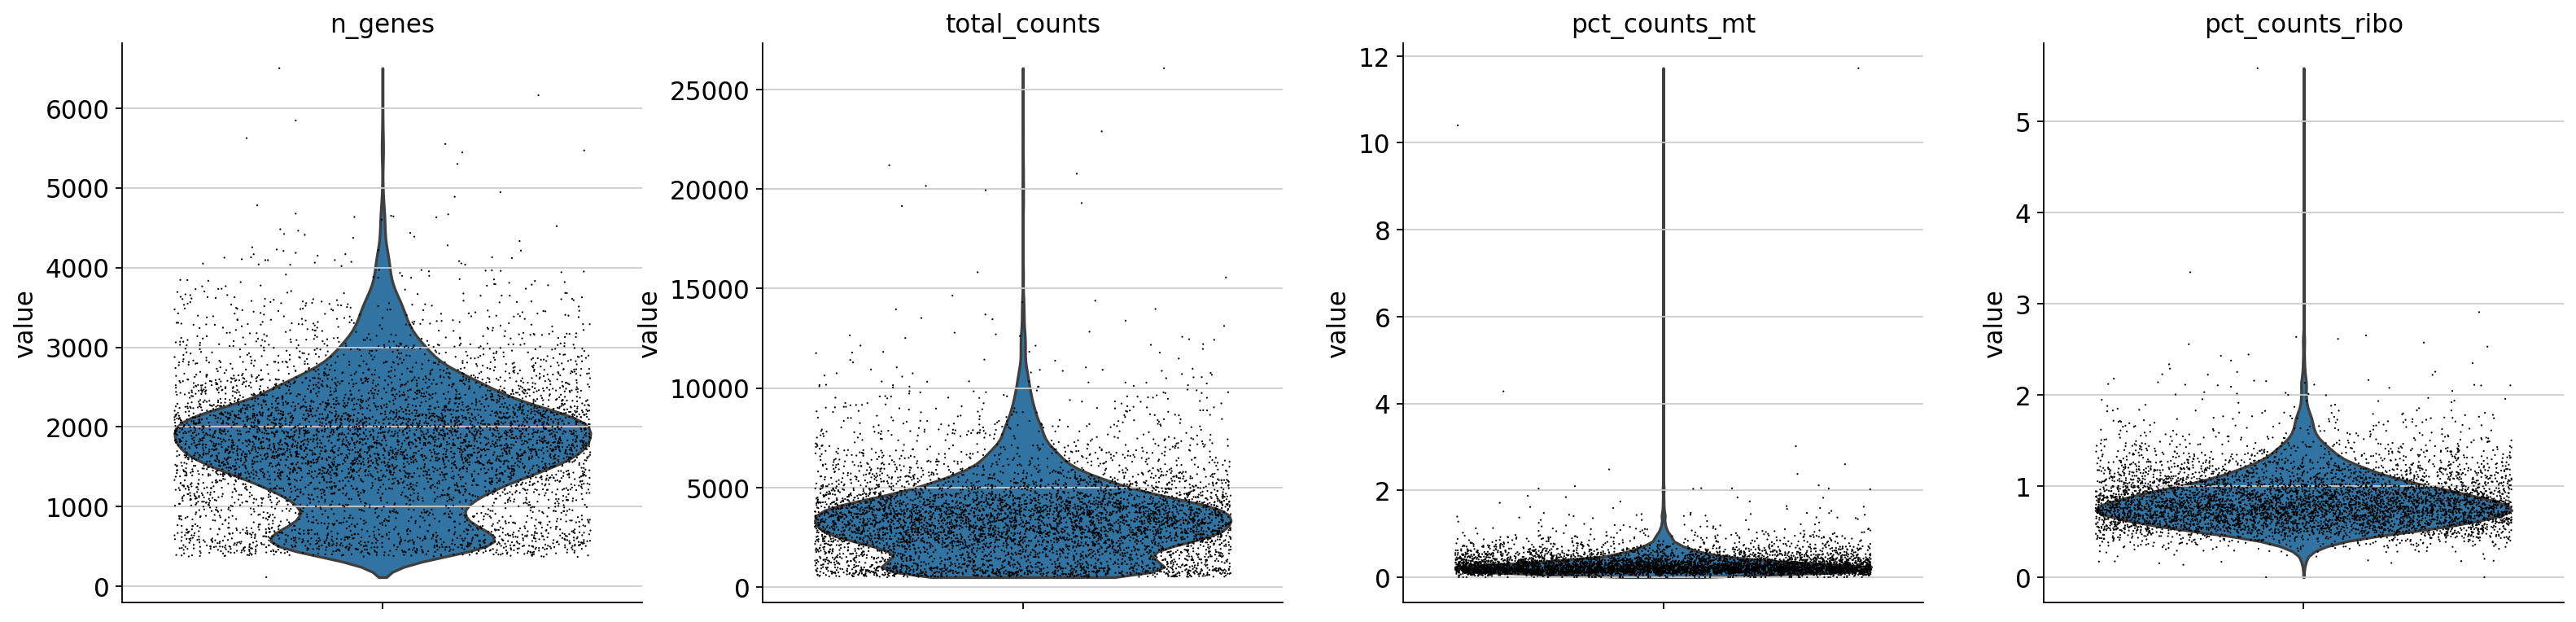

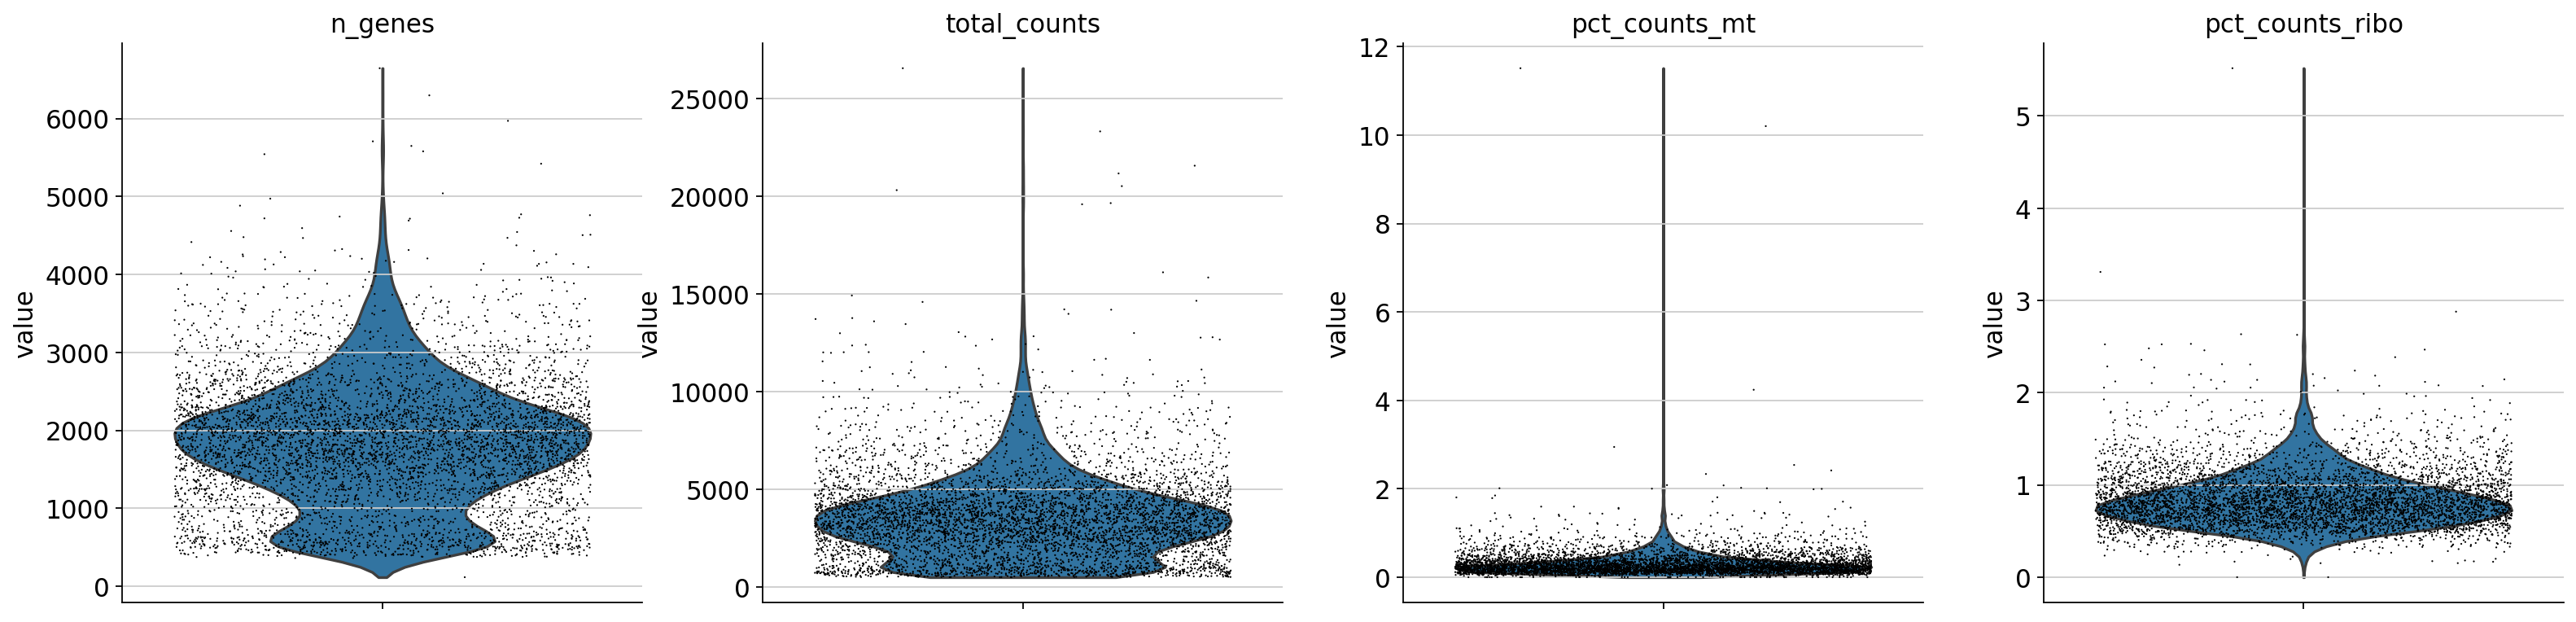

In [263]:
for i in range(numberobj):
    sc.pl.violin(locals()[object_names[i]], ['n_genes', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True,size =1)#,save= object_names[i]+"_prefilter_all.pdf")
    plt.show()

In [256]:
print("Median numbers without mitochondrial reads\n")
for i in range(numberobj):
    print(object_names[i],'\t',"\tmedian genes/nuclei:",np.median(locals()[object_names[i]].obs['n_genes']), 
            "\tmedian reads/nuclei:",np.median(locals()[object_names[i]].obs['total_counts']),
           "\tmean genes/nuclei:",int(np.mean(locals()[object_names[i]].obs['n_genes'])),
         "\tmean reads/nuclei:",  int(np.mean(locals()[object_names[i]].obs['total_counts'])))

Median numbers without mitochondrial reads

adata_CNR0176487_old 	 	median genes/nuclei: 1792.5 	median reads/nuclei: 3300.0 	mean genes/nuclei: 1789 	mean reads/nuclei: 3532
adata_CNR0176487_new 	 	median genes/nuclei: 1822.0 	median reads/nuclei: 3353.5 	mean genes/nuclei: 1820 	mean reads/nuclei: 3589


### Save preprocessed files

In [21]:
for i in range(numberobj):
    locals()[object_names[i]].write(os.path.join('data/'+object_names[i][6:]+'_preprocessed.h5ad'))

### Plots

In [22]:
for i in range(numberobj):
    sc.external.pl.scrublet_score_distribution(locals()[object_names[i]], scale_hist_obs='log', scale_hist_sim='linear', figsize=(8, 3),show=True,return_fig=True)